# 微博数据分析

数据包含微博 15 个影响力较大的新闻媒体 2020-1-20 到 2020-3-25 号微博正文，包含字段：微博id，微博正文，原始图片url，微博视频url，发布位置，发布时间，发布工具，点赞数，转发数，评论数


## 导入库/参数设置

In [1]:
import os
import jieba
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [2]:
start_date = "2020-1-20"
font_path = "./Microsoft YaHei Mono.ttf"
media_data_path = "../data/media_data"
stop_words_path = "../data/dictionary/stop_words.txt"
positive_words_path = "../data/dictionary/ntusd-positive.txt"
negative_words_path = "../data/dictionary/ntusd-negative.txt"
expanded_dict_path = "../data/dictionary/jieba_expanded_dict.txt"

## 获取数据

In [3]:
def get_data(file_path):
    total = pd.DataFrame()
    # read all xlsx files
    for root, dirs, files in tqdm(os.walk(file_path)):
        # merge all post
        for file in files:
            df = pd.read_csv(os.path.join(root, file))
            df.drop(columns=["微博id", "原始图片url", "微博视频url", "发布位置", "发布工具"], inplace=True)
            total = total.append(df)
    total.columns = ["post", "time", "like", "repost", "comment"]
    total["time"] = pd.to_datetime(total["time"]).dt.date
    total.sort_values("time", inplace=True)
    total.reset_index(drop=True, inplace=True)
    # concatenate posts by date
    # total = total.groupby("time")["post"].sum()
    return total
data = get_data(media_data_path)

16it [00:00, 21.86it/s]


## 查看数据基本信息

In [4]:
data.shape

(53741, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53741 entries, 0 to 53740
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post     53741 non-null  object
 1   time     53741 non-null  object
 2   like     53741 non-null  int64 
 3   repost   53741 non-null  int64 
 4   comment  53741 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


In [6]:
data.head()

,post,time,like,repost,comment
0,无外售票！全城唯一！快抱带你去内部场提前5天看中国女排《夺冠》 原图,2020-01-20,16,5,7
1,【习近平对新型冠状病毒感染的肺炎疫情作出重要指示】习近平对新型冠状病毒感染的肺炎疫情作出重要...,2020-01-20,984,154,179
2,【广州#5名外来务工人员举报非法排污获20万元奖励#】2018年1月20日凌晨4时，李某伟伙...,2020-01-20,1551,48,146
3,【#对暴力伤医说不#！】2019年12月28日，基本医疗卫生与健康促进法经全国人大常委会表决...,2020-01-20,13965,4472,1443
4,【警笛声呼啸而来 #车主拉链式变道让行消防车#】1月20日，南京消防特勤一中队前往一处火灾现...,2020-01-20,8040,570,281


In [7]:
data["time"].value_counts()

2020-01-25    1077
2020-02-02    1003
2020-01-27    1001
2020-01-28     983
2020-01-24     963
              ... 
2020-02-23     703
2020-03-23     700
2020-02-19     672
2020-01-20     607
2020-03-24      96
Name: time, Length: 65, dtype: int64

## 每日发布微博数量分布图

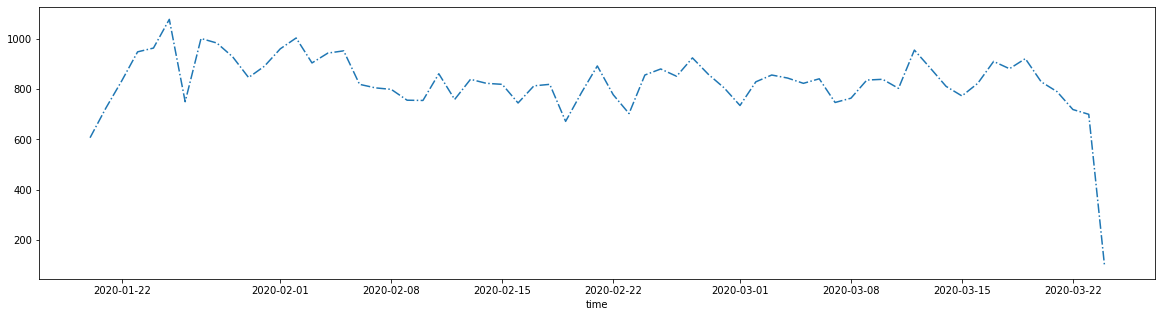

In [8]:
fig1, ax1 = plt.subplots(figsize=(20, 5))
df = data.groupby("time").count()["post"]
df.plot(ax=ax1, style='-.')
plt.show()

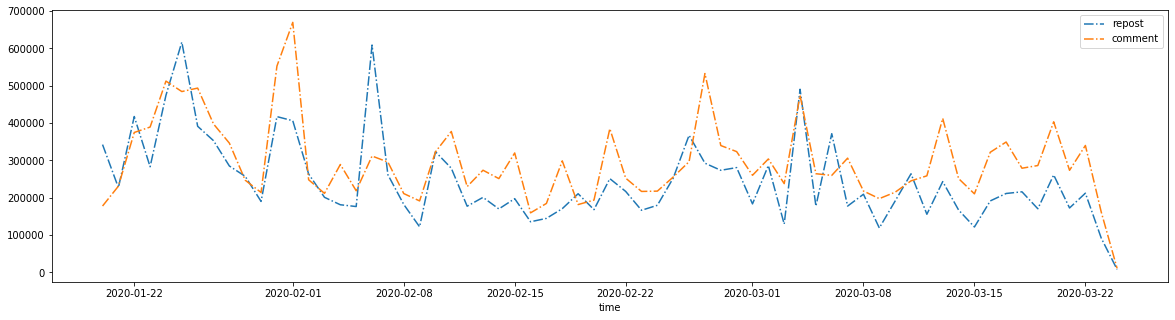

In [9]:
fig2, ax2 = plt.subplots(figsize=(20, 5))
df = data.groupby("time").sum()[["repost", "comment"]]
df.plot(ax=ax2, style='-.')
plt.show()

## 微博正文内容预处理

In [10]:
# only keep chinese text
data["post"] = data["post"].str.replace("[^\u4e00-\u9fa5]","")

In [11]:
# post segmentation
jieba.load_userdict(expanded_dict_path)
data["post"] = data["post"].apply(lambda x: " ".join(jieba.cut(x, cut_all=False)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\const\AppData\Local\Temp\jieba.cache
Loading model cost 0.631 seconds.
Prefix dict has been built succesfully.


In [12]:
# get all kinds of vocabulary
def get_vocab(vocab_path):
    vacab = set()
    with open(vocab_path, encoding="utf-8") as f:
        vocab_list = [x.strip() for x in f.readlines()]
        vacab = set(vocab_list)
    return vacab

## 制作高频词词云

In [13]:
# load stop words
stopwords = get_vocab(stop_words_path)

In [34]:
def gen_wordcloud(text, save_to_file):
    wc = WordCloud(font_path=font_path, width=1000, height=860, scale=2, max_words=100, stopwords=stopwords, background_color="white", collocations=False).generate(text)
    wc.to_file(save_to_file)
    plt.imshow(wc)
    plt.axis("off")

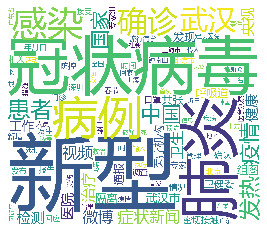

In [36]:
# generate wordcloud by date
date = "2020-1-20"
gen_wordcloud(data.groupby("time")["post"].sum()[pd.to_datetime(date).date()], os.path.join("../data/wordcloud", date + ".png"))

## 获取情绪高频词

In [1]:
positive_words = get_vocab(positive_words_path)
negative_words = get_vocab(negative_words_path)

NameError: name 'get_vocab' is not defined

In [29]:
from collections import Counter
postwords_list = data.groupby("time")["post"].sum()[pd.to_datetime("2020-1-20").date()].split()
pos_words_list = [word for word in postwords_list if word in positive_words]
neg_words_list = [word for word in postwords_list if word in negative_words]
pos_counter = Counter(pos_words_list)
pos_counter.most_common(10)

[('治疗', 136),
 ('卫生', 119),
 ('健康', 116),
 ('进行', 113),
 ('专家', 86),
 ('管理', 72),
 ('接受', 61),
 ('安全', 53),
 ('了解', 48),
 ('注意', 44)]

In [30]:
neg_counter = Counter(neg_words_list)
neg_counter.most_common(10)

[('感染', 402),
 ('患者', 236),
 ('发热', 222),
 ('隔离', 106),
 ('疾病', 57),
 ('受伤', 54),
 ('没有', 52),
 ('死亡', 46),
 ('死刑', 45),
 ('活动', 45)]